In [ ]:
# Install PyTorch and other required libraries
!pip install torch torchvision matplotlib
!pip install scikit-learn


In [ ]:
import os
import zipfile
import requests

from google.colab import drive
drive.mount('/content/drive')

# Define URL for dataset download
dataset_url = 'https://archive.ics.uci.edu/static/public/920/jute+pest+dataset.zip'
dataset_path = '/content/drive/MyDrive/PR- CNN Assignment/jute_pest_dataset.zip'

# Download the dataset
response = requests.get(dataset_url)
with open(dataset_path, 'wb') as f:
    f.write(response.content)

# Unzip the dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/PR- CNN Assignment/jute_pest_dataset')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/PR- CNN Assignment/jute_pest_dataset/Jute_Pest_Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/PR- CNN Assignment/jute_pest_dataset1')

In [ ]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define the path to your dataset directory
dataset_dir = '/content/drive/MyDrive/PR- CNN Assignment/jute_pest_dataset1/Jute_Pest_Dataset'

# Define transformations for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize images to 224x224 for DenseNet
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images (ImageNet stats)
])

# Load the dataset
train_dataset = ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=transform)
val_dataset = ImageFolder(root=os.path.join(dataset_dir, 'val'), transform=transform)
test_dataset = ImageFolder(root=os.path.join(dataset_dir, 'test'), transform=transform)



# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the number of classes
num_classes = len(train_dataset.classes)
print(f'Number of classes: {num_classes}')


Number of classes: 17


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Load DenseNet-121 pre-trained on ImageNet
model = models.densenet121(pretrained=True)

# Modify the final layer to match the number of classes in your dataset
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 149MB/s]


In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define learning rate scheduler (optional)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # To store metrics
    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Train the model
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Evaluate on validation set
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

        # Step the learning rate scheduler
        scheduler.step()

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_accuracies

# Train the model
model, train_losses, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20
)



Epoch 0/19
----------
Training Loss: 0.6968 Acc: 0.7922
Validation Loss: 1.0079 Acc: 0.7506
Epoch 1/19
----------
Training Loss: 0.2890 Acc: 0.9126
Validation Loss: 1.1470 Acc: 0.7288
Epoch 2/19
----------
Training Loss: 0.2057 Acc: 0.9367
Validation Loss: 0.8896 Acc: 0.7990
Epoch 3/19
----------
Training Loss: 0.1543 Acc: 0.9533
Validation Loss: 0.8046 Acc: 0.8184
Epoch 4/19
----------
Training Loss: 0.1178 Acc: 0.9640
Validation Loss: 0.7886 Acc: 0.8111
Epoch 5/19
----------
Training Loss: 0.1134 Acc: 0.9649
Validation Loss: 0.7433 Acc: 0.8571
Epoch 6/19
----------
Training Loss: 0.1148 Acc: 0.9629
Validation Loss: 0.6541 Acc: 0.8499
Epoch 7/19
----------
Training Loss: 0.0293 Acc: 0.9936
Validation Loss: 0.5571 Acc: 0.8959
Epoch 8/19
----------
Training Loss: 0.0088 Acc: 0.9983
Validation Loss: 0.5312 Acc: 0.8959
Epoch 9/19
----------
Training Loss: 0.0071 Acc: 0.9989
Validation Loss: 0.5131 Acc: 0.9007
Epoch 10/19
----------
Training Loss: 0.0047 Acc: 0.9997
Validation Loss: 0.5112

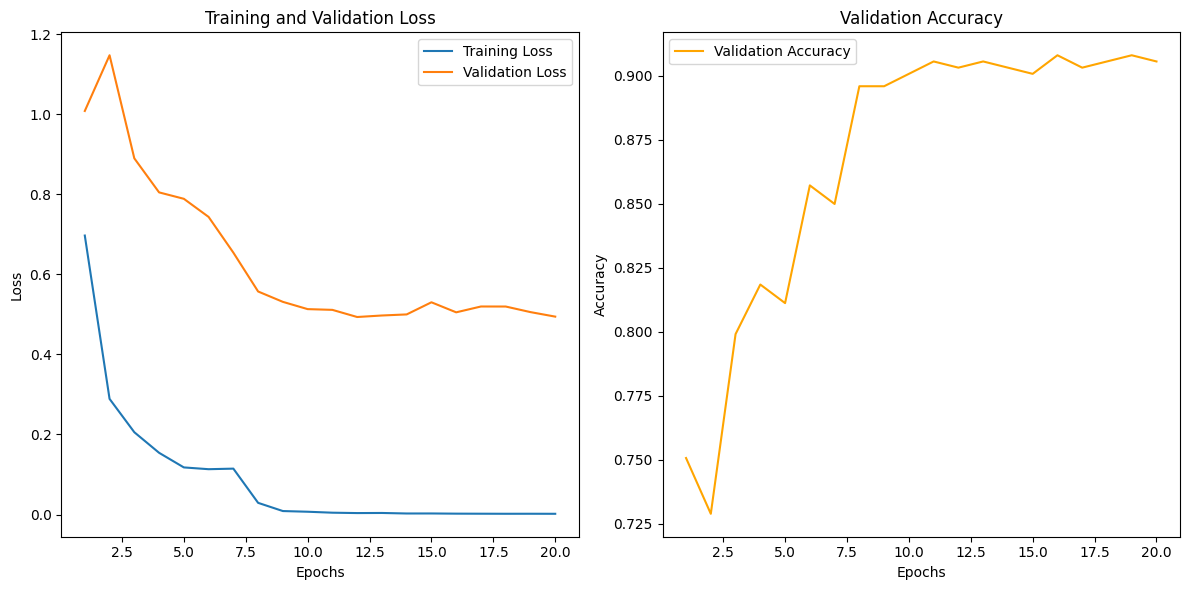

In [ ]:
# Plotting training loss and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {test_acc:.4f}')

# Evaluate the model
evaluate_model(model, test_loader)


Test Accuracy: 0.9789


In [ ]:
from PIL import Image
import numpy as np

# Function for making predictions on new images
def predict_image(model, img_path):
    model.eval()
    img = Image.open(img_path)
    img = transform(img).unsqueeze(0).to(device)  # Apply transforms and add batch dimension

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

    return train_dataset.classes[preds.item()]

